In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table



In [2]:
# read MaNGA examples
# extract sky spectra from blue and red channels
# plot both channel spectra
# outline sky spectra cleaning: fiber masking, pixel masking, outliers
# separate continuum from emission lines

# examples path
manga_path = "/disk-a/mejia/Research/UNAM/lvm-drp/lvmdrp/docs/nb/_data-manga"

filenames = sorted(os.listdir(manga_path))
filenames

['mgSFrame-b1-00198570.fits.gz', 'mgSFrame-r1-00198570.fits.gz']

In [3]:
blue_sky_path = os.path.join(manga_path, filenames[0])
blue_sky = fits.open(blue_sky_path)

blue_sky.info()

Filename: /disk-a/mejia/Research/UNAM/lvm-drp/lvmdrp/docs/nb/_data-manga/mgSFrame-b1-00198570.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     190   ()      
  1  FLUX          1 ImageHDU       194   (4112, 709)   float32   
  2  IVAR          1 ImageHDU        10   (4112, 709)   float32   
  3  MASK          1 ImageHDU        10   (4112, 709)   int32   
  4  WSET          1 BinTableHDU     30   1R x 4C   [8A, D, D, 4254D]   
  5  LSFPOST       1 ImageHDU        10   (4112, 709)   float32   
  6  LSFPRE        1 ImageHDU        10   (4112, 709)   float32   
  7  SLITMAP       1 BinTableHDU     86   1423R x 34C   [12A, J, J, 8A, J, J, 8A, J, J, J, E, J, K, J, 5A, J, 3A, J, J, J, D, D, D, D, D, D, E, E, E, J, J, J, 5E, 8A]   
  8  XPOS          1 ImageHDU        10   (4112, 709)   float32   
  9  SUPERFLAT     1 ImageHDU        10   (4112, 709)   float32   
 10  AIRSET        1 BinTableHDU     30   1R x 4C   [8A, D, D, 4254D]   
 1

In [4]:
red_sky_path = os.path.join(manga_path, filenames[1])
red_sky = fits.open(red_sky_path)

red_sky.info()

Filename: /disk-a/mejia/Research/UNAM/lvm-drp/lvmdrp/docs/nb/_data-manga/mgSFrame-r1-00198570.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     190   ()      
  1  FLUX          1 ImageHDU       194   (4128, 709)   float32   
  2  IVAR          1 ImageHDU        10   (4128, 709)   float32   
  3  MASK          1 ImageHDU        10   (4128, 709)   int32   
  4  WSET          1 BinTableHDU     36   1R x 7C   [8A, D, D, 4254D, E, E, E]   
  5  LSFPOST       1 ImageHDU        10   (4128, 709)   float32   
  6  LSFPRE        1 ImageHDU        10   (4128, 709)   float32   
  7  SLITMAP       1 BinTableHDU     86   1423R x 34C   [12A, J, J, 8A, J, J, 8A, J, J, J, E, J, K, J, 5A, J, 3A, J, J, J, D, D, D, D, D, D, E, E, E, J, J, J, 5E, 8A]   
  8  XPOS          1 ImageHDU        10   (4128, 709)   float32   
  9  SUPERFLAT     1 ImageHDU        10   (4128, 709)   float32   
 10  AIRSET        1 BinTableHDU     36   1R x 7C   [8A, D, D, 425

In [5]:
import pandas as pd
from io import StringIO

from enum import IntFlag


manga_2d_bitmask_table = StringIO("""<table class="table table-condensed table-bordered">
<thead>
<tr>
<th>Bit name</th>
<th>Binary digit</th>
<th>Value</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td colspan="4"><i>The following mask bits are for fibers:</i></td>
</tr>
<tr>
<td>NOPLUG</td>
<td class="text-left">0</td>
<td class="text-left">1</td>
<td>Fiber not listed in plugmap file.</td>
</tr>
<tr>
<td>BADTRACE</td>
<td class="text-left">1</td>
<td class="text-left">2</td>
<td>Bad trace.</td>
</tr>
<tr>
<td>BADFLAT</td>
<td class="text-left">2</td>
<td class="text-left">4</td>
<td>Low counts in fiberflat.</td>
</tr>
<tr>
<td>BADARC</td>
<td class="text-left">3</td>
<td class="text-left">8</td>
<td>Bad arc solution.</td>
</tr>
<tr>
<td>MANYBADCOLUMNS</td>
<td class="text-left">4</td>
<td class="text-left">16</td>
<td>More than 10% of pixels are bad columns.</td>
</tr>
<tr>
<td>MANYREJECTED</td>
<td class="text-left">5</td>
<td class="text-left">32</td>
<td>More than 10% of pixels are rejected in extraction.</td>
</tr>
<tr>
<td>LARGESHIFT</td>
<td class="text-left">6</td>
<td class="text-left">64</td>
<td>Large spatial shift between flat and object position.</td>
</tr>
<tr>
<td>BADSKYFIBER</td>
<td class="text-left">7</td>
<td class="text-left">128</td>
<td>Sky fiber shows extreme residuals.</td>
</tr>
<tr>
<td>NEARWHOPPER</td>
<td class="text-left">8</td>
<td class="text-left">256</td>
<td>Within 2 fibers of a whopping fiber (exclusive).</td>
</tr>
<tr>
<td>WHOPPER</td>
<td class="text-left">9</td>
<td class="text-left">512</td>
<td>Whopping fiber, with a very bright source.</td>
</tr>
<tr>
<td>SMEARIMAGE</td>
<td class="text-left">10</td>
<td class="text-left">1024</td>
<td>Smear available for red and blue cameras.</td>
</tr>
<tr>
<td>SMEARHIGHSN</td>
<td class="text-left">11</td>
<td class="text-left">2048</td>
<td>S/N sufficient for full smear fit.</td>
</tr>
<tr>
<td>SMEARMEDSN</td>
<td class="text-left">12</td>
<td class="text-left">4096</td>
<td>S/N only sufficient for scaled median fit.</td>
</tr>
<tr>
<td>DEADFIBER</td>
<td class="text-left">13</td>
<td class="text-left">8192</td>
<td>Broken fiber according to metrology files.</td>
</tr>
<tr>
<td colspan="4"><i>The following mask bits are for a pixel:</i></td>
</tr>
<tr>
<td>SATURATION</td>
<td class="text-left">14</td>
<td class="text-left">16384</td>
<td>Pixel considered saturated.</td>
</tr>
<tr>
<td>BADPIX</td>
<td class="text-left">15</td>
<td class="text-left">32768</td>
<td>Pixel flagged in badpix reference file.</td>
</tr>
<tr>
<td>COSMIC</td>
<td class="text-left">16</td>
<td class="text-left">65536</td>
<td>Pixel flagged as cosmic ray.</td>
</tr>
<tr>
<td>NEARBADPIXEL</td>
<td class="text-left">17</td>
<td class="text-left">131072</td>
<td>Bad pixel within 3 pixels of trace.</td>
</tr>
<tr>
<td>LOWFLAT</td>
<td class="text-left">18</td>
<td class="text-left">262144</td>
<td>Flat field less than 0.5.</td>
</tr>
<tr>
<td>FULLREJECT</td>
<td class="text-left">19</td>
<td class="text-left">524288</td>
<td>Pixel fully rejected in extraction model fit (INVVAR=0).</td>
</tr>
<tr>
<td>PARTIALREJECT</td>
<td class="text-left">20</td>
<td class="text-left">1048576</td>
<td>Some pixels rejected in extraction model fit.</td>
</tr>
<tr>
<td>SCATTEREDLIGHT</td>
<td class="text-left">21</td>
<td class="text-left">2097152</td>
<td>Scattered light significant.</td>
</tr>
<tr>
<td>CROSSTALK</td>
<td class="text-left">22</td>
<td class="text-left">4194304</td>
<td>Cross-talk significant.</td>
</tr>
<tr>
<td>NOSKY</td>
<td class="text-left">23</td>
<td class="text-left">8388608</td>
<td>Sky level unknown at this wavelength (INVVAR=0).</td>
</tr>
<tr>
<td>BRIGHTSKY</td>
<td class="text-left">24</td>
<td class="text-left">16777216</td>
<td>Sky level &gt; flux + 10*(flux_err) AND sky &gt; 1.25 * median(sky,99 pixels).</td>
</tr>
<tr>
<td>NODATA</td>
<td class="text-left">25</td>
<td class="text-left">33554432</td>
<td>No data available in combine B-spline (INVVAR=0).</td>
</tr>
<tr>
<td>COMBINEREJ</td>
<td class="text-left">26</td>
<td class="text-left">671108864</td>
<td>Rejected in combine B-spline.</td>
</tr>
<tr>
<td>BADFLUXFACTOR</td>
<td class="text-left">27</td>
<td class="text-left">134217728</td>
<td>Low flux-calibration or flux-correction factor.</td>
</tr>
<tr>
<td>BADSKYCHI</td>
<td class="text-left">28</td>
<td class="text-left">268435456</td>
<td>Relative chi2 &gt; 3 in sky residuals at this wavelength.</td>
</tr>
<tr>
<td>REDMONSTER</td>
<td class="text-left">29</td>
<td class="text-left">536870912</td>
<td>Contiguous region of bad chi2 in sky residuals (with threshhold of relative chi2 &gt; 3).</td>
</tr>
<tr>
<td>3DREJECT</td>
<td class="text-left">30</td>
<td class="text-left">1073741824</td>
<td>Used in RSS file, indicates should be rejected when making 3D cube.</td>
</tr>
</tbody>
</table>""")

bmask_table = pd.read_html(manga_2d_bitmask_table)[0].rename(columns=lambda name: name.replace(" ", "_"))
bmask_table = bmask_table.drop(index=[0,15]).reset_index(drop=True)
bmask_table

class MaNGABitmask(IntFlag):
    NOPLUG  = 1
    BADTRACE  = 2
    BADFLAT  = 4
    BADARC  = 8
    MANYBADCOLUMNS  = 16
    MANYREJECTED  = 32
    LARGESHIFT  = 64
    BADSKYFIBER  = 128
    NEARWHOPPER  = 256
    WHOPPER  = 512
    SMEARIMAGE  = 1024
    SMEARHIGHSN  = 2048
    SMEARMEDSN  = 4096
    DEADFIBER  = 8192
    SATURATION  = 16384
    BADPIX  = 32768
    COSMIC  = 65536
    NEARBADPIXEL  = 131072
    LOWFLAT  = 262144
    FULLREJECT  = 524288
    PARTIALREJECT  = 1048576
    SCATTEREDLIGHT  = 2097152
    CROSSTALK  = 4194304
    NOSKY  = 8388608
    BRIGHTSKY  = 16777216
    NODATA  = 33554432
    COMBINEREJ  = 671108864
    BADFLUXFACTOR  = 134217728
    BADSKYCHI  = 268435456
    REDMONSTER  = 536870912
    _3DREJECT  = 1073741824

In [6]:
blue_ipix, blue_fpix = int(blue_sky["AIRSET"].data[0]["XMIN"]), int(blue_sky["AIRSET"].data[0]["XMAX"])
red_ipix, red_fpix = int(red_sky["AIRSET"].data[0]["XMIN"]), int(red_sky["AIRSET"].data[0]["XMAX"])
nsed, blue_ncoef, blue_nwav = *blue_sky["AIRSET"].data["COEFF"][0].shape, blue_fpix-blue_ipix+1
nsed, red_ncoef, red_nwav = *red_sky["AIRSET"].data["COEFF"][0].shape, red_fpix-red_ipix+1
blue_wave_rss = np.zeros((nsed, blue_nwav))
red_wave_rss = np.zeros((nsed, red_nwav))
for ised in range(nsed):
    blue_poly = np.polynomial.Legendre(blue_sky["AIRSET"].data["COEFF"][0][ised], domain=(blue_ipix,blue_fpix))
    blue_wave_rss[ised] = 10**blue_poly(np.arange(blue_ipix, blue_fpix+1))
    
    red_poly = np.polynomial.Legendre(red_sky["AIRSET"].data["COEFF"][0][ised], domain=(red_ipix,red_fpix))
    red_wave_rss[ised] = 10**red_poly(np.arange(red_ipix, red_fpix+1))

Text(0, 0.5, 'flux')

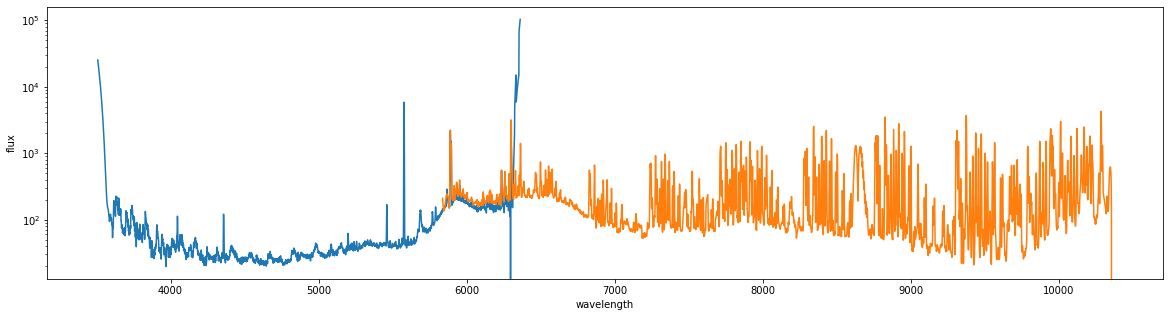

In [7]:
ised = 20

blue_mask = blue_sky["MASK"].data[ised] == 0
red_mask = red_sky["MASK"].data[ised] == 0


plt.figure(figsize=(20,5))
plt.semilogy(blue_wave_rss[ised][blue_mask], blue_sky["SKY"].data[ised][blue_mask])
plt.semilogy(red_wave_rss[ised][red_mask], red_sky["SKY"].data[ised][red_mask])
plt.xlabel("wavelength")
plt.ylabel("flux")


In [9]:
# sources of inspiration:
# https://spectrum.readthedocs.io/en/latest/api/spectrum.spectrum.Spectrum.html#spectrum.spectrum.Spectrum

import warnings
import copy

import numpy as np
from scipy import interpolate
# could implement fallback to np.interp if scipy is not available

from astropy import table
import astropy.units as u
import astropy.constants as const
try:
    from astropy.extern import six
except ImportError:
    import six
from astropy.modeling import models, fitting

# These are functions in order to emphasize that they do stuff to spectra,
# it's not a property of the spectrum.
# Or put everything for single spectrum in spectrum class?
# bin_up is not for flux spectrum.
# should use np.sum() for count number spectrum -> Inheritance diagram
# currently use doppler_optical - make different options (e.g. variable)
# add way to change units, e.g. wave in km/s, flux at different scale
# Allow None for slice to go to end of array? Or just tell people to use np/inf with proper units?
# change COS spectrum init, so that I can initialize a spectrum form a spectrum (need to copy disp etc)
# investigate why deepcopy(sepctrum) does not copy dispersion and how to fix that -> maybe just stick this info into 'meta' which is already handeled by table class?
# implement devision to return "flux ratio object" (which could just be spectrum with a different flux name)?
# make slice_XXX accept list of  ranges, e.g. left and right of line.

class InvalidSpectrumValueException(Exception):
    pass

def xcorr(base, spectra, steps, **kwargs):
    '''cross-correlate spectral segments in a certain range

    Cross-correlate one of more spectra to a base spectrum. This can be used to find
    the relative radial velocity.
    The implementation interpolates each spectra for each value in steps.
    For cases where the base and the spectra are both on the same regular wavelength
    grid, it is much faster to use ``np.correlate`` on the flux arrays directly.

    Parameters
    ----------
    base : :class:`~spectrum.spectrum.Spectrum`
       All spectra in ``speclist`` will be correlated against this spectrum.
       This also defines the dispersion scale.
    spectra : Spectrum or list of spectra
        List of :class:`~spectrum.spectrum.Spectrum` with 'WAVELENGTH' and 'FLUX' columns
    steps: astropy.Quantity
        List or array of steps to test for the cross-correlation. For each value in ``steps``
        the spectrum in question is shifted and then interpolated on the dispersion scale of
        ``base``. ``steps`` need not be regularly spaced. Typically, this will have units of
        km/s.

    All other keyword arguments are passed to :meth:`~Spectrum.interpol`.

    Returns
    -------
    res : array of len(speclist)
        shift relative to the spectrum ``base``

    '''
    if not isinstance(spectra[0], Spectrum):
        # input might be single spectrum and not list of Spectra
        spectra = [spectra]
    if not isinstance(spectra[0], Spectrum):
        # No excuse any longer!
        raise ValueError(
            '`spectra` must be a spectrum instance or a list of spectra.')

    shifts = np.zeros(len(spectra)) * steps[0].unit
    cor = np.zeros(steps.shape)
    for j in range(len(spectra)):
        for i, s in enumerate(steps):
            testspec = spectra[j].copy()
            testspec.shift_rv(s)
            cor[i] = (base.flux * testspec.interpol(base.disp,
                      **kwargs).flux).sum().value
            if not np.all(np.isfinite(cor)):
                raise InvalidSpectrumValueException('''Cross-correlation results in nan or inf.
Fill invalid flux values before calling xcorr and/or
reduce the wavelength range of base to avoid edge effects when spectra are interpolated.''')
        shifts[j] = steps[np.argmax(cor)]
    return shifts


class Spectrum(table.Table):
    '''
    To make more general:
    make "dispersion" or something similar and allow to set that as an alias for
    what I currently call wavelength
    '''
    fluxname = 'FLUX'  # default to None, here, make setter in init for general
    dispersion = None  # set to default 'WAVELENGTH' for specific COSspectrum
    uncertainty = None  # can be removed when uncertainties are part of NDData

    def __init__(self, *args, **kwargs):
        if 'dispersion' in kwargs:
            self.dispersion = kwargs.pop('dispersion')
        if 'uncertainty' in kwargs:
            self.uncertainty = kwargs.pop('uncertainty')

        super(Spectrum, self).__init__(*args, **kwargs)

    def _copy_property_names(self, spec):
        spec.fluxname = copy.copy(self.fluxname)
        spec.dispersion = copy.copy(self.dispersion)
        spec.uncertainty = copy.copy(self.uncertainty)

    def _new_from_slice(self, slice_):
        spec = super(Spectrum, self)._new_from_slice(slice_)
        self._copy_property_names(spec)
        return spec

    def __getitem__(self, item):
        spec = super(Spectrum, self).__getitem__(item)
        if isinstance(item, (tuple, list)) and all(isinstance(x, six.string_types)
                                                     for x in item):
            self._copy_property_names(spec)
        return spec


    def copy(self, copy_data=True):
        '''
        Return a copy of the table.


        Parameters
        ----------
        copy_data : bool
            If `True` (the default), copy the underlying data array.
            Otherwise, use the same data array
        '''
        spec = super(Spectrum, self).copy(copy_data=copy_data)
        self._copy_property_names(spec)
        return spec


    @classmethod
    def read(cls, filename):
        '''specific to COS - can be made into a Reader'''
        data = []

        tab = table.Table.read(filename)
        for c in tab.columns:
            if len(tab[c].shape) == 2:
                data.append(table.Column(data=tab[c].data.flatten(),
                                         unit=tab[c].unit,
                                         name=c))
        flattab = cls(data, meta=tab.meta, dispersion='WAVELENGTH', uncertainty='ERROR')
        # COS is not an echelle spectrograph, so there never is any overlap
        flattab.sort('WAVELENGTH')
        return flattab

    @property
    def flux(self):
        if self.fluxname is None:
            raise ValueError('Need to set spectrum.fluxname="NAME".')
        return self[self.fluxname].data * self[self.fluxname].unit


    @property
    def disp(self):
        # Currently table columns are not quantities.
        # see issue astropy/#2486
        if self.dispersion is None:
            raise ValueError('Need to set spectrum.dispersion="NAME".')
        return self[self.dispersion].data * self[self.dispersion].unit

    @property
    def error(self):
        # Can be removed when NDData really supports uncertainties
        if self.uncertainty is None:
            raise ValueError('Need to set spectrum.uncertainty="NAME".')
        return self[self.uncertainty].data * self[self.uncertainty].unit


    def _slice_disp(self, bounds, equivalencies = []):
        b0 = bounds[0].to(self.disp.unit, equivalencies=equivalencies)
        b1 = bounds[1].to(self.disp.unit, equivalencies=equivalencies)
        ind = (self.disp >= b0) & (self.disp <= b1)
        return self[ind]


    def slice_disp(self, bounds):
        '''Return a portion of the spectrum between given dispersion values

        Parameters
        ----------
        bounds : list of two quantities
            [lower bound, upper bound] in dispersion of spectrally equivalent unit

        Returns
        -------
        spec : :class:`~spectrum.Spectrum`
            spectrum that is limited to the range from bound[0] to bound[1]

        See also
        --------
        slice_rv
        '''
        equil = u.spectral()
        return self._slice_disp(bounds, equivalencies=equil)


    def slice_rv(self, bounds, rest):
        '''Return a portion of the spectrum between given radial velocity values

        Parameters
        ----------
        bounds : list of two quantities
            [lower bound, upper bound] in radial velocity
        rest : :class:`~astropy.quantity.Quantity`
            Rest wavelength/frequency of spectral feature

        Returns
        -------
        spec : :class:`~spectrum.Spectrum`
            spectrum that is limited to the range from bound[0] to bound[1]

        See also
        --------
        slice_disp
        '''
        equil = u.spectral()
        equil.extend(u.doppler_optical(rest))
        return self._slice_disp(bounds, equivalencies=equil)


    def normalize(self, model, **kwargs):
        #fit model and normalize flux and error
        # Makes sense here or have user interact with flux directly?
        raise NotImplementedError


    def shift_rv(self, rv):
        '''Shift spectrum by rv

        Parameters
        ----------
        rv : :class:`~astropy.quantity.Quantity`
            radial velocity (positive value will red-shift the spectrum, negative
            value will blue-shift the spectrum)
        '''
        self[self.dispersion] = (self.disp.to(u.m, equivalencies=u.spectral()) * (
                1.*u.dimensionless_unscaled+rv/const.c)).to(
                self.disp.unit, equivalencies=u.spectral()).value


    # overload add, substract, divide to interpol automatically?

    def bin_up(self, factor, other_cols={}):
        '''Bin up an array by factor ``factor``.

        If the number of elements in spectrum is not n * factor with n=1,2,3,...
        the remaining bins at the end are discarded.
        By itself, this function knows how to deal with dispersion, flux and uncertainty.
        The parameter `other_cols` can be used to specify how to bin up other columns in
        the spectrum. Columns with no rule for binning up are discarded.

        Parameters
        ----------
        x : array
            data to be binned
        factor : integer
            binning factor
        other_cols : dictionary
            The keys in this dictionary are the names of columns in the spectrum, its values
            are functions that define how to bin up other columns (e.g. for a column that holds
            a mask or data quality flag it does not make sense to calculate the mean).
            The function is called on an array of shape [N, factor] and needs to return
            a [N] array. For example `other_cols={'quality': lambda x: np.max(x, axis=1)}`
            would assign the new bin the maximum of all quality values in the original bins
            that contribute to the new bin.

        Returns
        -------
        spec : :class:`~spectrum.Spectrum`
            A new spectrum object.
        '''
        n = len(self) // factor
        # makes a copy incl. all metadata and column formats
        # Which cols to keep?
        keepcols = set([x for x in [self.dispersion, self.fluxname, self.uncertainty] if x is not None])
        keepcols = keepcols.union(set(other_cols.keys()))
        spec = self[list(keepcols)][:n*factor:factor]
        spec[self.dispersion] = (self.disp[:n*factor].reshape((n, factor))).mean(axis=1)
        if self.uncertainty is None:
            spec[self.fluxname] = (self.flux[:n*factor].reshape((n, factor))).mean(axis=1)
        else:
            f, e = np.ma.average(self.flux[:n*factor].reshape((n, factor)), weights=1./(self.error[:n*factor].reshape((n, factor)))**2., axis=1, returned=True)
            spec[self.fluxname] = f
            spec[self.uncertainty] = (1./e)**0.5
        for col in other_cols:
            spec[col] = other_cols[col](self[col][:n*factor].reshape((n, factor)))
        return spec


    def interpol(self, new_dispersion, **kwargs):
        '''Interpolate a spectrum onto a new dispersion axis.

        Parameters
        ----------
        new_dispersion : :class:`~astropy.quantity.Quantity`
           The new dispersion axis.

        All other keywords are passed directly to scipy.interpolate.interp1d.

        Returns
        -------
        spec : :class:`~spectrum.Spectrum`
            A new spectrum.
        '''
        new_disp = new_dispersion.to(self.disp.unit, equivalencies=u.spectral())

        f_flux = interpolate.interp1d(self.disp, self.flux, **kwargs)
        newflux = f_flux(new_disp)

        names = [self.dispersion, self.fluxname]
        vals = [new_disp, newflux]

        if self.uncertainty is not None:
            warnings.warn('The uncertainty column is interpolated.' +
                         'Bins are no longer independent and might require scaling.' +
                         'It is up to the user the decide if the uncertainties are still meaningful.')
            names.append(self.uncertainty)
            f_uncert = interpolate.interp1d(self.disp, self.error, **kwargs)
            vals.append(f_uncert(new_disp))

        # TBD Add other columns that should be interpolated to names, vals here
        # Add switch or keyword to select them

        newcols = []
        for name, val in zip(names, vals):
            col = self[name]
            newcols.append(col.__class__(data=val, name=name,
                                         description=col.description, unit=col.unit,
                                         format=col.format, meta=col.meta))
        return self.__class__(newcols, meta=self.meta, dispersion=self.dispersion,
                              uncertainty=self.uncertainty)

    def crosscorrelate(self, dispersion, flux):
        '''or as a module level function?
        Do full thing here with steps, return best fit etc? or only calculate one spesific
        step?
        '''
        raise NotImplementedError



In [10]:
def wave_little_interpol(wavelist):
    '''Make a wavelengths array for merging echelle orders with little interpolation.

    In echelle spectra we often have the situation that neighboring orders overlap
    a little in wavelength space::

        aaaaaaaaaaaa
                 bbbbbbbbbbbbb
                          ccccccccccccc

    When merging those spectra, we want to keep the original wavelength grid where possible.
    This way, we only need to interpolate on a new wavelength grid where different orders
    overlap (here ``ab`` or ``bc``) and can avoid the dangers of flux interpolation in
    those wavelength region where only one order contributes.

    This algorithm has limitations, some are fundamental, some are just due to the 
    implementation and may be removed in future versions:

    - The resulting grid is **not** equally spaced, but the step size should not vary too much.
    - The wavelength arrays need to be sorted in increasing order.
    - There has to be overlap between every order and every order has to have some overlap
      free region in the middle.

    Parameters
    ----------
    wavelist : list of 1-dim ndarrays
        input list of wavelength

    Returns
    -------
    waveout : ndarray
        wavelength array that can be used to co-adding all echelle orders.
    '''
    mins = np.array([min(w) for w in wavelist])
    maxs = np.array([max(w) for w in wavelist])

    if np.any(np.argsort(mins) != np.arange(len(wavelist))):
        raise ValueError(
            'List of wavelengths must be sorted in increasing order.')
    if np.any(np.argsort(mins) != np.arange(len(wavelist))):
        raise ValueError(
            'List of wavelengths must be sorted in increasing order.')
    if not np.all(maxs[:-1] > mins[1:]):
        raise ValueError('Not all orders overlap.')
    if np.any(mins[2:] < maxs[:-2]):
        raise ValueError('No order can be completely overlapped.')

    waveout = [wavelist[0][wavelist[0] < mins[1]]]
    for i in range(len(wavelist)-1):
        #### overlap region ####
        # No assumptions on how bin edges of different orders match up
        # overlap start and stop are the last and first "clean" points.
        overlap_start = np.max(waveout[-1])
        overlap_end = np.min(wavelist[i+1][wavelist[i+1] > maxs[i]])
        # In overlap region patch in a linear scale with slightly different step.
        dw = overlap_end - overlap_start
        step = 0.5 * \
            (np.mean(np.diff(wavelist[i])) + np.mean(np.diff(wavelist[i+1])))
        n_steps = int(dw / step + 0.5)

        wave_overlap = np.linspace(
            overlap_start + step,  overlap_end - step, n_steps - 1)
        waveout.append(wave_overlap)

        #### next region without overlap ####
        if i < (len(wavelist) - 2):  # normal case
            waveout.append(
                wavelist[i+1][(wavelist[i+1] > maxs[i]) & (wavelist[i+1] < mins[i+2])])
        else:                       # last array - no more overlap behind that
            waveout.append(wavelist[i+1][(wavelist[i+1] > maxs[i])])

    return np.hstack(waveout)


def coadd_simple(spectra, dispersion=None, **kwargs):
    '''A simple way to coadd several spectra

    All spectra are interpolated to ``dispersion`` and for each wavelengths bin the
    mean over all n spectra is calculated. The reported uncertainty is just the mean
    of all uncertainties scaled by 1/sqrt(n).
    Nan values are ignored in the calculation of the mean. Thus, this method can be used
    if not all spectra have the same wavelength range. Supply the keyword
    ``bounds_error=False``, so that the interpolation returns ``nan`` outside the range
    covered by the spectrum.
        

    Parameters
    ----------
    spectra : list of :class:`~spectrum.Spectrum` instances
        spectra to be averaged
    dispersion : :class:`~astropy.quantity.Quantity`
        dispersion axis of the new spectrum. If ``None`` the dispersion axis of the 
        first spectrum in ``spectra`` is used.
    
    All other parameters are passed to :meth:`~spectrum.Spectrum.interpol`.

    Returns
    -------
    spec : :class:`~spectrum.Spectrum`

    See also
    --------
    coadd_errorweighted
    '''
    if dispersion is None:
        dispersion = spectra[0].disp
    fluxes = np.zeros((len(spectra), len(dispersion)))
    # since numpy operation will destroy the flux unit, need to convert here by hand
    # until that is fixed (fluxes can be NDdata once that works with quantities)
    fluxunit = spectra[0].flux.unit
    errors = np.zeros_like(fluxes)
    for i, s in enumerate(spectra):
        s_new = s.interpol(dispersion, **kwargs)
        fluxes[i, :] = s_new.flux.to(fluxunit)
        if (errors is None) or s.uncertainty is None:
            errors = None
        else:
            errors[i, :] = s_new.error.to(fluxunit)

    # This can be simplified considerably as soon as masked quantities exist.
    fluxes = np.ma.fix_invalid(fluxes)
    fluxmask = np.ma.getmaskarray(fluxes)
    fluxes = fluxes.mean(axis=0).filled(fill_value=np.nan) * fluxunit

    if errors is None:
        return Spectrum(data=[dispersion, fluxes],
                        names=[spectra[0].dispersion, 'FLUX'],
                        dispersion=spectra[0].dispersion,
                        )
    else:
        errors = np.ma.fix_invalid(errors)
        if fluxmask.sum() > 0:
            # In case flux has more entries masked than error
            errors[fluxmask] = np.ma.masked
        errors = (errors.mean(axis=0)/np.sqrt((~np.ma.getmaskarray(errors)
                                               ).sum(axis=0))).filled(np.nan)*fluxunit
        return Spectrum(data=[dispersion, fluxes, errors],
                        names=[spectra[0].dispersion,
                               'FLUX', spectra[0].uncertainty],
                        dispersion=spectra[0].dispersion, uncertainty=spectra[0].uncertainty,
                        )


def coadd_errorweighted(spectra, dispersion=None, **kwargs):
    '''A simple way to coadd several spectra

    All spectra are interpolated to ``dispersion`` and for each wavelengths bin the
    mean over all n spectra is calculated. The reported uncertainty is just the mean
    of all uncertainties scaled by 1/sqrt(n).
    Nan values are ignored in the calculation of the mean. Thus, this method can be used
    if not all spectra have the same wavelength range. Supply the keyword
    ``bounds_error=False``, so that the interpolation returns ``nan`` outside the range
    covered by the spectrum.
        

    Parameters
    ----------
    spectra : list of :class:`~spectrum.Spectrum` instances
        spectra to be averaged
    dispersion : :class:`~astropy.quantity.Quantity`
        dispersion axis of the new spectrum. If ``None`` the dispersion axis of the 
        first spectrum in ``spectra`` is used.
    
    All other parameters are passed to :meth:`~spectrum.Spectrum.interpol`.

    Returns
    -------
    spec : :class:`~spectrum.Spectrum`

    See also
    --------
    coadd_simple
    '''
    if dispersion is None:
        dispersion = spectra[0].disp
    fluxes = np.ma.zeros((len(spectra), len(dispersion)))
    # since numpy operation will destroy the flux unit, need to convert here by hand
    # until that is fixed (fluxes can be NDdata once that works with quantities)
    fluxunit = spectra[0].flux.unit
    errors = np.zeros_like(fluxes)
    for i, s in enumerate(spectra):
        s_new = s.interpol(dispersion, **kwargs)
        fluxes[i, :] = s_new.flux.to(fluxunit)
        if s.uncertainty is None:
            raise ValueError(
                's.uncertainty needs to be set for every spectrum')
        else:
            errors[i, :] = s_new.error.to(fluxunit)

    # First, make sure there is no flux defined if there is no error.
    errors = np.ma.fix_invalid(errors)
    if np.ma.is_masked(errors):
        fluxes[errors.mask] = np.ma.masked
    # This can be simplified considerably as soon as masked quantities exist.
    fluxes = np.ma.fix_invalid(fluxes)
    # There are no masked quantities yet, so make sure they are filled here.
    fluxes = np.ma.average(fluxes, axis=0, weights=1. /
                           errors**2.).filled(np.nan) * fluxunit
    errors = np.sqrt(1. / np.ma.sum(1./errors**2.,
                     axis=0).filled(np.nan)) * fluxunit
    # check explicitly here every time, because that makes hard to find bugs and
    # astropy quantity behaviour might change.
    assert not np.ma.isMaskedArray(fluxes)
    assert not np.ma.isMaskedArray(errors)

    return Spectrum(data=[dispersion, fluxes, errors],
                    names=[spectra[0].dispersion,
                           'FLUX', spectra[0].uncertainty],
                    dispersion=spectra[0].dispersion, uncertainty=spectra[0].uncertainty,
                    )


In [11]:
ised = 20
blue_sed = Spectrum(
    data=[
        blue_sky["SKY"].data[ised]*u.erg/u.cm**2/u.s/u.AA,
        blue_wave_rss[ised]*u.AA,
        np.divide(1, np.sqrt(blue_sky["IVAR"].data[ised]), where=blue_sky["IVAR"].data[ised] > 0)*u.erg/u.cm**2/u.s/u.AA
    ],
    names=["FLUX", "WAVE", "ERROR"],
    dispersion="WAVE",
    uncertainty="ERROR"
)
red_sed = Spectrum(
    data=[
        red_sky["SKY"].data[ised]*u.erg/u.cm**2/u.s/u.AA,
        red_wave_rss[ised]*u.AA,
        np.divide(1, np.sqrt(red_sky["IVAR"].data[ised]), where=red_sky["IVAR"].data[ised] > 0)*u.erg/u.cm**2/u.s/u.AA
    ],
    names=["FLUX", "WAVE", "ERROR"],
    dispersion="WAVE",
    uncertainty="ERROR"
)

joint_wave = wave_little_interpol([blue_sed["WAVE"], red_sed["WAVE"]])

In [12]:
joint_sky = coadd_errorweighted([blue_sed, red_sed], dispersion=joint_wave*u.AA, bounds_error=False)
joint_sky = joint_sky[(joint_sky["WAVE"]>=3650)&(joint_sky["WAVE"]<=10000)]

nan_mask = np.isnan(joint_sky["FLUX"])|np.isnan(joint_sky["ERROR"])
joint_sky["FLUX"] = np.interp(joint_sky["WAVE"], joint_sky["WAVE"][~nan_mask], joint_sky["FLUX"][~nan_mask])
joint_sky["ERROR"] = np.interp(joint_sky["WAVE"], joint_sky["WAVE"][~nan_mask], joint_sky["ERROR"][~nan_mask])

/home/mejia/.local/tmp/ipykernel_1064675/1315494165.py:323: UserWarning: The uncertainty column is interpolated.Bins are no longer independent and might require scaling.It is up to the user the decide if the uncertainties are still meaningful.
  warnings.warn('The uncertainty column is interpolated.' +


Text(0, 0.5, 'flux')

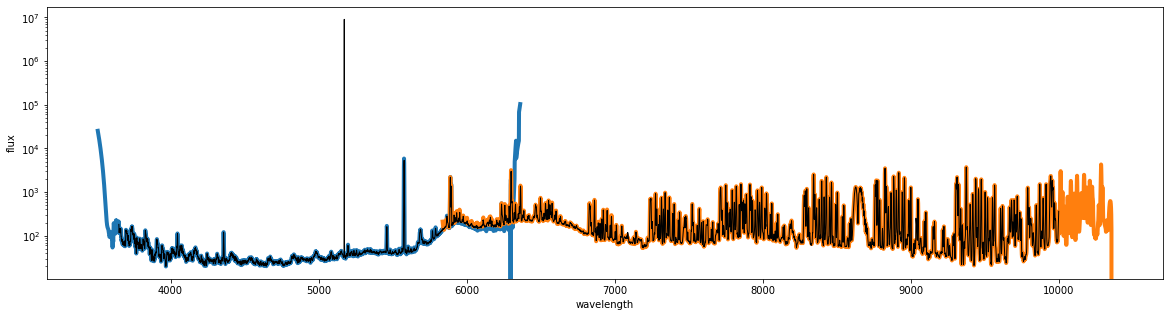

In [13]:
plt.figure(figsize=(20, 5))
plt.semilogy(blue_wave_rss[ised][blue_mask], blue_sky["SKY"].data[ised][blue_mask], lw=4)
plt.semilogy(red_wave_rss[ised][red_mask], red_sky["SKY"].data[ised][red_mask], lw=4)
plt.semilogy(joint_sky["WAVE"], joint_sky["FLUX"], color="k", lw=1)
plt.xlabel("wavelength")
plt.ylabel("flux")


Text(0, 0.5, 'flux')

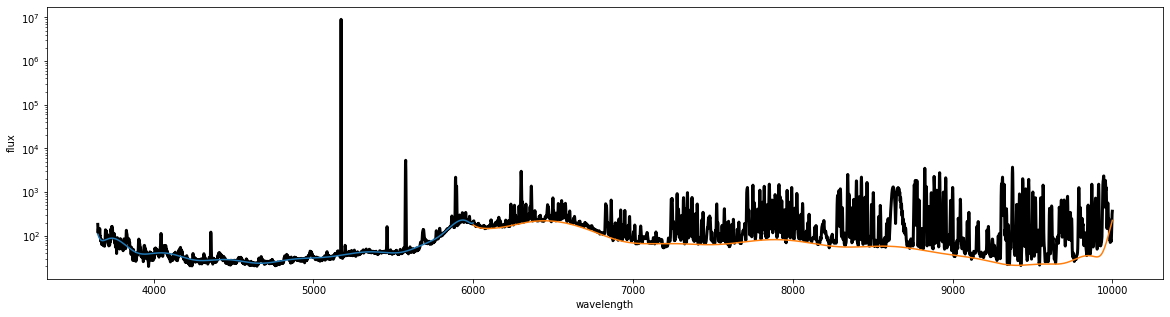

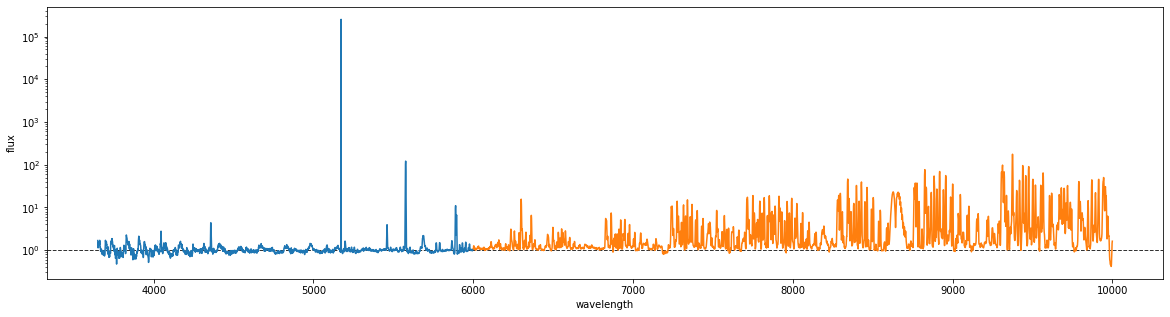

In [19]:
from specutils.fitting import fit_generic_continuum
from specutils import Spectrum1D as Spec1D, SpectralRegion
from specutils.manipulation import extract_region
from astropy.modeling import models
from astropy.modeling import fitting
from scipy.stats import binned_statistic


sky_sed = Spec1D(flux=joint_sky["FLUX"].value*u.erg/u.s/u.cm**2/u.AA, spectral_axis=joint_sky["WAVE"].value*u.AA)

b_mask = joint_sky["WAVE"]<=6000
r_mask = joint_sky["WAVE"]>6000

blue = extract_region(sky_sed, region=SpectralRegion(0*u.AA, 6000*u.AA))
red = extract_region(sky_sed, region=SpectralRegion(6000*u.AA, 90000*u.AA))

min, xe, _ = binned_statistic(
    x=red.wavelength,
    values=red.flux,
    statistic=np.min,
    bins=np.logspace(
        start=np.log10(red.wavelength.value.min()),
        stop=np.log10(red.wavelength.value.max()),
        num=50
    )
)
xbin = (xe[1:] + xe[:-1])/2

red_bin = Spec1D(flux=min*u.erg/u.s/u.cm**2/u.AA, spectral_axis=xbin*u.AA)

# plt.figure(figsize=(20, 5))
# plt.semilogy(red.wavelength, red.flux)
# plt.semilogy(xbin, min, "ok")

blue_cont = fit_generic_continuum(
    spectrum=blue,
    model=models.Legendre1D(20),
    median_window=31,
    fitter=fitting.LinearLSQFitter()
)
red_cont = fit_generic_continuum(
    spectrum=red_bin,
    model=models.Legendre1D(20),
    median_window=1,
    fitter=fitting.LinearLSQFitter()
)

plt.figure(figsize=(20, 5))
plt.semilogy(sky_sed.wavelength, sky_sed.flux, color="k", lw=3)
plt.semilogy(blue.wavelength, blue_cont(blue.wavelength))
plt.semilogy(red.wavelength, red_cont(red.wavelength))
plt.xlabel("wavelength")
plt.ylabel("flux")

plt.figure(figsize=(20, 5))
plt.axhline(1, ls="--", lw=1, color="0.2")
plt.semilogy(blue.wavelength, blue.flux/blue_cont(blue.wavelength))
plt.semilogy(red.wavelength, red.flux/red_cont(red.wavelength))
plt.xlabel("wavelength")
plt.ylabel("flux")
